In [35]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import os
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator, InterpolatedUnivariateSpline

In [36]:
import shap
import spektral
from spektral.layers import GCNConv

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors

In [38]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [39]:
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [41]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [42]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [43]:
def readTrainData():
    path = 'sources/'
    df = pd.read_csv(path+'AppML_InitialProject_train.csv')
    return df
trainDf = readTrainData()

In [44]:
trainDf

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,p_eta,p_phi,p_charge,p_Truth_isElectron,p_truth_pt,p_truth_phi,p_truth_eta,p_Truth_Energy,p_truth_pdgId,p_truth_parent_pdgId
0,29.49,0.105563,0.111953,0.000000,0.020473,0.746226,0.671689,0.000000,0.000000,0.063020,...,-1.425603,-0.859392,-1.0,1,2815.96020,-0.828581,-1.425959,6198.1055,11,22
1,17.50,0.001889,0.001663,0.007252,0.009059,0.944349,0.967633,0.955249,0.135955,0.059219,...,-0.380698,-1.014216,-1.0,1,39207.48000,-1.014038,-0.380727,42083.5980,11,23
2,30.50,-0.001041,-0.001294,0.006346,0.008852,0.976413,0.959573,0.937885,0.171204,-0.105151,...,0.591333,2.983345,1.0,1,64328.51600,2.981821,0.592576,75957.2800,-11,23
3,46.49,0.000606,0.002833,0.005985,0.009785,0.950910,0.945615,0.966444,0.263183,-0.026020,...,1.006222,0.503709,1.0,1,46312.54700,0.503773,1.006411,71814.3700,-11,23
4,31.50,0.024148,0.067781,0.034671,0.009486,0.797810,0.670594,0.087876,0.373575,0.219026,...,-1.674565,1.063436,-1.0,1,858.65717,1.060842,-1.676498,2375.8310,11,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,36.50,0.492974,1.262969,0.025889,0.015685,0.472843,0.684885,0.287160,0.304126,-0.148706,...,0.540303,-3.105240,1.0,0,32911.66400,-3.105209,0.540659,37840.4920,211,2
179996,31.50,0.076596,0.572484,0.117248,0.009608,0.958072,0.936306,0.076313,0.274991,-0.109284,...,0.541794,1.783658,-1.0,0,13656.11700,1.783581,0.541314,15706.8370,-211,-213
179997,30.50,1.674750,2.193961,0.019816,0.011431,0.787651,0.670452,0.343338,0.112708,0.017916,...,0.140798,-3.116873,-1.0,0,5216.26300,-3.116861,0.141633,5270.5180,-211,223
179998,36.50,0.040680,0.043097,0.008589,0.012814,0.619827,0.598550,0.342507,0.298415,-0.095350,...,1.321953,-0.292104,1.0,0,18433.30000,-0.292308,1.321826,37022.7270,211,113


In [45]:
def readTestData():
    path = 'sources/'
    df_classification = pd.read_csv(path+'AppML_InitialProject_test_classification.csv')
    df_clustering = pd.read_csv(path+'AppML_InitialProject_test_clustering.csv')
    df_regression = pd.read_csv(path+'AppML_InitialProject_test_regression.csv')
    return df_classification, df_clustering, df_regression
testDf_clsf, testDf_clst, testDf_regs = readTestData()

In [46]:
testDf_clsf

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr0,pX_E7x11_Lr1,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge
0,36.50,0.000463,-0.000876,0.002665,0.009376,0.937129,0.959152,0.984819,0.326582,0.238975,...,1868.9042,16364.933,33013.040,76.07219,1868.9042,16364.933,20527.746,0.325806,1.086726,1.0
1,48.50,0.050439,0.069607,0.028404,0.013048,0.700572,0.590812,0.000000,0.000000,-0.000000,...,0.0000,50501.242,182841.720,19097.24800,0.0000,50501.242,11949.609,-2.450711,0.354888,-1.0
2,32.50,0.002050,0.003029,0.007395,0.010444,0.963112,0.959066,0.985446,0.353189,0.666636,...,905.5605,13357.994,22515.666,314.40604,905.5605,13357.994,35849.570,0.140523,0.733514,-1.0
3,28.50,0.027664,0.043439,0.011525,0.011258,0.962601,0.948064,0.984326,0.345560,0.240108,...,0.0000,32864.360,61438.790,975.66034,0.0000,32864.360,18349.436,1.948463,-2.287875,1.0
4,20.49,-0.008994,-0.011444,0.007584,0.010042,0.965167,0.955182,0.993133,0.268595,0.139726,...,1970.9218,19733.762,51706.180,1139.15390,1970.9218,19761.928,54046.035,-0.726814,2.317220,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,34.50,0.450859,0.494188,0.000000,0.000000,0.000800,-0.004000,0.000000,0.000000,0.079010,...,26463.0250,36277.290,36799.094,154.07170,26463.0250,33269.820,15200.653,1.475503,-0.021296,1.0
59996,29.49,0.265472,0.720422,0.008196,0.010941,0.811148,0.919864,0.031265,0.258551,0.131573,...,5135.4090,11495.376,27522.310,170.00873,5135.4090,11495.376,12442.076,-0.858835,-1.879149,1.0
59997,49.50,0.192758,0.273979,0.126550,0.013108,0.923015,0.936289,0.000163,0.128086,0.324599,...,8782.7180,9258.149,55382.840,12358.93300,8782.7180,9258.149,44505.652,-1.699267,1.073709,-1.0
59998,35.50,0.345104,0.436920,0.034847,0.012072,0.802757,0.834948,0.000000,0.000000,-0.000000,...,0.0000,47620.070,217042.200,13176.30400,0.0000,47620.070,53259.473,2.468021,-2.511265,-1.0


In [47]:
testDf_clst

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr0,pX_E7x11_Lr1,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge
0,48.50,0.002621,0.003149,0.000421,0.012095,0.873118,0.837550,0.000000,0.000000,0.231180,...,26052.62100,18763.9260,13017.211,-57.970287,26052.62100,18820.9820,48257.5500,-1.505234,1.175829,-1.0
1,39.49,0.014003,0.008869,0.041638,0.010281,0.925357,0.940242,0.950630,0.135817,0.303750,...,0.00000,18765.0780,119595.300,6125.241700,0.00000,18734.8180,33935.6500,1.995196,-1.292367,1.0
2,25.49,0.007870,0.009702,0.004270,0.010424,0.939269,0.958781,0.984077,0.391043,0.041206,...,4592.48900,21492.4510,28992.730,596.587800,4592.48900,21492.4510,44557.0900,-0.797741,-1.067770,-1.0
3,28.50,0.001414,-0.004248,0.012807,0.013539,0.916596,0.913783,0.991349,0.516933,-0.000000,...,0.00000,50264.5740,51692.957,-31.530766,0.00000,50264.5740,9718.2190,-2.276100,1.133550,1.0
4,23.50,0.000988,-0.023321,0.010335,0.010201,0.816869,0.921899,0.941022,0.390446,1.016616,...,688.87744,42935.8480,68867.445,590.925900,688.87744,42935.8480,25790.2190,1.871118,-0.622213,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,41.49,0.228431,0.522523,0.004807,0.015567,0.755933,0.467267,0.545339,0.469139,0.102263,...,2119.91600,19943.8500,43843.484,2144.287000,2119.91600,19865.7100,13294.7360,-0.125354,1.901233,-1.0
19996,33.50,0.046517,0.324909,0.006538,0.011492,0.845218,0.831077,0.085903,0.220015,-0.015957,...,3875.20310,7355.2130,26095.656,1062.750000,3875.20310,7355.2130,12671.7760,1.015306,2.975697,1.0
19997,20.49,0.903955,1.183762,0.073063,0.013042,0.804634,0.686622,0.804377,0.249756,0.024105,...,2255.14300,6096.4795,17283.645,4235.365000,2255.14300,6096.4795,33278.6700,0.653617,0.767755,-1.0
19998,37.50,0.381709,0.706533,0.019395,0.011556,0.852819,0.860969,0.110009,0.221309,-0.039300,...,3007.39580,15878.5160,46878.400,4535.643000,3007.39580,15878.5160,3054.2612,0.528555,-1.317966,-1.0


In [48]:
testDf_regs

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr0,pX_E7x11_Lr1,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge
0,36.50,-0.006231,-0.004756,0.000000,0.011021,0.939902,0.933349,0.940145,0.240089,0.742557,...,9555.348000,12439.4170,30005.940,30.267273,9555.348000,12439.4170,27331.0250,-1.356775,2.437287,1.0
1,27.50,0.069768,0.066464,0.008597,0.010425,0.947139,0.956537,0.954305,0.378152,0.053620,...,-32.166813,7150.0110,11357.543,223.495700,-32.166813,7150.0110,14839.9460,0.758425,0.424543,1.0
2,38.50,0.031475,0.032103,0.006010,0.009790,0.971168,0.975648,0.982716,0.261825,0.348544,...,930.292700,13870.4400,37771.043,235.996550,930.292700,13870.4400,47934.7800,0.451583,1.543324,1.0
3,44.49,0.255715,0.598475,0.023568,0.017368,0.759111,0.413124,0.000000,0.000000,-0.000000,...,0.000000,30461.0350,101239.040,17743.662000,0.000000,30461.0350,1547.0653,2.386935,-2.541257,-1.0
4,46.49,-0.002943,0.000832,0.005014,0.009650,0.978518,0.975219,0.989922,0.400065,0.328410,...,716.887100,16007.3790,25491.777,280.913300,716.887100,16007.3790,38393.7200,-0.595902,2.444494,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,45.49,0.639871,0.931700,0.047565,0.014313,0.751563,0.481971,0.049648,0.222836,0.182798,...,1919.307000,5069.9614,12153.055,1186.884900,2981.303000,3690.7695,13794.3930,-0.908004,-2.500148,-1.0
39996,23.50,0.035678,0.035608,0.006525,0.013475,0.553298,0.772175,0.485771,0.300058,-0.134290,...,12320.759000,9364.2210,18286.041,3545.511200,12481.400000,10613.4300,24288.5330,1.532268,1.387485,-1.0
39997,30.50,0.506169,1.408881,0.004859,0.012234,0.749204,0.798801,0.289237,0.297742,-0.078994,...,3829.177200,10531.5870,22682.910,922.046450,4448.633300,8834.5300,46904.3700,0.871931,0.338847,-1.0
39998,34.50,0.029772,0.015480,0.013480,0.012181,0.855929,0.755831,0.303872,0.201922,-0.044859,...,0.000000,29014.9770,87093.380,2459.278600,0.000000,28916.5590,14215.0450,1.921771,-0.448903,1.0


In [49]:
def compare(test, train):
    setTest = set(test.columns)
    setTrain = set(train.columns)
    tags = setTrain - setTest
    return tags

In [50]:
# print(compare(testDf_clsf, trainDf))
# print(compare(testDf_regs, trainDf))
# print(compare(testDf_clst, trainDf))
missingTags = compare(testDf_clsf, trainDf) | compare(testDf_regs, trainDf) | compare(testDf_clst, trainDf)
missingTags


{'p_Truth_Energy',
 'p_Truth_isElectron',
 'p_truth_eta',
 'p_truth_parent_pdgId',
 'p_truth_pdgId',
 'p_truth_phi',
 'p_truth_pt'}

* `FNNClassifier` builds a TensorFlow feedforward neural network classifier
* `CNNClassifier` builds a TensorFlow convolution neural network classifier
* `GNNClassifier` builds a TensorFlow graph neural network classifier
* it can be used as other sklearn classifiers or xgboost having these public functions(methods)
  * `fit`
  * `predict`

In [143]:
class FNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_classes, epochs=50):
        self.num_classes = num_classes
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        # Check if the model exists and if input_dim has changed
        if self.model is None or self.input_dim != X.shape[1]:
            self.input_dim = X.shape[1]  # Update the input_dim based on current X
            # Rebuild the model
            self.model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(128, activation='relu', input_shape=(self.input_dim,)),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(self.num_classes, activation='softmax')
            ])
            self.model.compile(optimizer='adam',
                               loss='sparse_categorical_crossentropy',
                               metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).argmax(axis=1)


In [52]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)  # Initialize first GCN layer
        self.conv2 = GCNConv(16, num_classes)  # Initialize second GCN layer

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # Pass data through first GCN layer
        x = F.relu(x)  # Apply ReLU non-linearity
        x = self.conv2(x, edge_index)  # Pass data through second GCN layer
        return F.log_softmax(x, dim=1)

In [53]:
class GNNClassifier:
    def __init__(self, num_classes, num_features, epochs=50):
        self.num_classes = num_classes
        self.num_features = num_features
        self.epochs = epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = GCN(num_features, num_classes).to(self.device)

    def fit(self, loader):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        for epoch in range(self.epochs):
            for batch in loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()
                output = self.model(batch.x, batch.edge_index)
                loss = F.nll_loss(output, batch.y)
                loss.backward()
                optimizer.step()

    def predict(self, loader):
        self.model.eval()
        all_predictions = []
        for batch in loader:
            batch = batch.to(self.device)
            output = self.model(batch.x, batch.edge_index)
            pred = output.max(dim=1)[1]
            all_predictions.extend(pred.cpu().numpy())
        return all_predictions

In [154]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, C=0.5, solver='lbfgs'),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt'),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=1.0),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, n_estimators=100, learning_rate=0.1, max_depth=3, objective='binary:logistic'),
    'FNN': FNNClassifier(num_classes=2, epochs=50),
    # 'GNN': GNNClassifier(num_classes=2, num_features=140, epochs=50),
}
classifiers.keys()

dict_keys(['LogisticRegression', 'RandomForest', 'AdaBoost', 'GradientBoosting', 'XGBoost', 'FNN'])

features = ["averageInteractionsPerCrossing",
            "p_Rhad1",
            "p_Rhad",
            "p_f3",
            "p_weta2",
            "p_Rphi",
            "p_Reta",
            "p_Eratio",
            "p_f1",
            "p_TRTPID",
            "p_numberOfInnermostPixelHits",
            "p_numberOfPixelHits",
            "p_numberOfSCTHits",
            "p_numberOfTRTHits",
            "p_TRTTrackOccupancy",
            "p_numberOfTRTXenonHits",
            "p_z0",
            "p_d0",
            "p_sigmad0",
            "p_dPOverP",
            "p_deltaEta1",
            "p_deltaPhiRescaled2",
            "p_etcone20",
            "p_etcone30",
            "p_etcone40",
            "p_ptcone20",
            "p_ptcone30",
            "p_ptcone40",
            "p_ptPU30",
            "p_vertex",
            "pX_E7x7_Lr2",
            "pX_E7x7_Lr3",
            "pX_E_Lr0_HiG",
            "pX_E_Lr0_MedG",
            "pX_E_Lr1_HiG",
            "pX_E_Lr1_LowG",
            "pX_E_Lr1_MedG",
            "pX_E_Lr2_HiG",
            "pX_E_Lr2_LowG",
            "pX_E_Lr2_MedG",
            "pX_E_Lr3_HiG",
            "pX_E_Lr3_MedG",
            "pX_MultiLepton",
            "pX_OQ",
            "pX_ambiguityType",
            "pX_asy1",
            "pX_author",
            "pX_barys1",
            "pX_core57cellsEnergyCorrection",
            "pX_deltaEta0",
            "pX_deltaEta1",
            "pX_deltaEta2",
            "pX_deltaEta3",
            "pX_deltaPhi0",
            "pX_deltaPhi1",
            "pX_deltaPhi2",
            "pX_deltaPhi3",
            "pX_deltaPhiFromLastMeasurement",
            "pX_deltaPhiRescaled0",
            "pX_deltaPhiRescaled1",
            "pX_deltaPhiRescaled3",
            "pX_e1152",
            "pX_e132",
            "pX_e235",
            "pX_e255",
            "pX_e2ts1",
            "pX_ecore",
            "pX_emins1",
            "pX_etcone20",
            "pX_etcone30",
            "pX_etcone40",
            "pX_f1core",
            "pX_f3core",
            "pX_maxEcell_energy",
            "pX_maxEcell_gain",
            "pX_maxEcell_time",
            "pX_maxEcell_x",
            "pX_maxEcell_y",
            "pX_maxEcell_z",
            "pX_nCells_Lr0_HiG",
            "pX_nCells_Lr0_MedG",
            "pX_nCells_Lr1_HiG",
            "pX_nCells_Lr1_LowG",
            "pX_nCells_Lr1_MedG",
            "pX_nCells_Lr2_HiG",
            "pX_nCells_Lr2_LowG",
            "pX_nCells_Lr2_MedG",
            "pX_nCells_Lr3_HiG",
            "pX_nCells_Lr3_MedG",
            "pX_neflowisol20",
            "pX_neflowisol30",
            "pX_neflowisol40",
            "pX_neflowisolcoreConeEnergyCorrection",
            "pX_pos",
            "pX_pos7",
            "pX_poscs1",
            "pX_poscs2",
            "pX_ptcone20",
            "pX_ptcone30",
            "pX_ptcone40",
            "pX_ptconecoreTrackPtrCorrection",
            "pX_ptvarcone20",
            "pX_ptvarcone30",
            "pX_ptvarcone40",
            "pX_r33over37allcalo",
            "pX_topoetcone20",
            "pX_topoetcone20ptCorrection",
            "pX_topoetcone30",
            "pX_topoetcone30ptCorrection",
            "pX_topoetcone40",
            "pX_topoetcone40ptCorrection",
            "pX_topoetconecoreConeEnergyCorrection",
            "pX_weta1",
            "pX_widths1",
            "pX_wtots1",
            "pX_e233",
            "pX_e237",
            "pX_e2tsts1",
            "pX_ehad1",
            "pX_emaxs1",
            "pX_fracs1",
            "pX_DeltaE",
            "pX_E3x5_Lr0",
            "pX_E3x5_Lr1",
            "pX_E3x5_Lr2",
            "pX_E3x5_Lr3",
            "pX_E5x7_Lr0",
            "pX_E5x7_Lr1",
            "pX_E5x7_Lr2",
            "pX_E5x7_Lr3",
            "pX_E7x11_Lr0",
            "pX_E7x11_Lr1",
            "pX_E7x11_Lr2",
            "pX_E7x11_Lr3",
            "pX_E7x7_Lr0",
            "pX_E7x7_Lr1",
            "p_pt_track",
            "p_eta",
            "p_phi",
            "p_charge",]

* `getCM`: Calculates the confusion matrix, accuracy, and fraction of wrong predictions.
  * `predictions`: Array of predicted labels
  * `true_labels`: Array of true labels
  * returns Tuple containing the confusion matrix, accuracy, and fraction of wrong predictions

In [56]:
def getCM(predictions, true_labels):
    # Initialize the confusion matrix
    N = np.zeros((2, 2), dtype=int)
    
    # Loop through all predictions and true labels to populate the confusion matrix
    for i in range(len(predictions)):
        # Increase the corresponding count in the confusion matrix
        N[true_labels[i]][predictions[i]] += 1

    # Calculate the fraction of wrong predictions
    fracWrong = float(N[0][1] + N[1][0]) / float(len(true_labels))
    
    # Calculate the accuracy
    accuracy = 1.0 - fracWrong
    
    return N, accuracy, fracWrong

In [57]:
def getConfusionMatrix(predictions, true_labels):
    return confusion_matrix(true_labels, predictions)

In [58]:
def showCM(predictions, true_labels):
    N, accuracy, fracWrong = getCM(predictions, true_labels)
    print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
    print("  First number in parenthesis is the estimate, second is the MC truth:")
    print("  True-Negative (0,0)  = ", N[0][0])
    print("  False-Negative (0,1) = ", N[0][1])
    print("  False-Positive (1,0) = ", N[1][0])
    print("  True-Positive (1,1)  = ", N[1][1])
    print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
    print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)

In [59]:
def saveToCsv(predictions, filename):
    df = pd.DataFrame(predictions)
    df.to_csv(filename, index=False)

* `getEdgeIndex` creates an edge_index tensor using the k-nearest neighbors approach.
* Parameters:
  * `X` (np.array): Feature matrix of shape (num_samples, num_features)
  * `k` (int): Number of nearest neighbors to connect each node with
* returns `edge_index` (torch.tensor): Tensor of shape (2, num_edges) for use in GNN

In [60]:
def getEdgeIndex(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Create edge index array
    edge_index = []
    num_nodes = X.shape[0]
    for i in range(num_nodes):
        for j in range(1, k+1):  # start from 1 to avoid self-loops
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])  # add reverse connection for undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index

In [79]:
def getClsfFeaturesKernel(trainDf, key, Nfeatures=20):
    classifier = classifiers[key]
    X_train = trainDf.drop(missingTags, axis=1)
    y_train = trainDf['p_Truth_isElectron']
    
    classifier.fit(X_train.values, y_train.values)

    # Tree Explainer for XGB
    if classifier == classifiers['XGBoost']:
        explainer = shap.TreeExplainer(classifier)
    else:
        explainer = shap.KernelExplainer(classifier.predict, shap.sample(X_train, 100))  # Using a sample for approximation

    shap_values = explainer.shap_values(shap.sample(X_train, 100))  # Again, using a sample for practicality

    # Calculate the mean absolute SHAP values for each feature
    shap_summaries = np.abs(shap_values).mean(axis=0)

    # Sort the features by their mean absolute SHAP value in descending order
    indices = np.argsort(shap_summaries)[::-1]

    top_features = X_train.columns[indices[:Nfeatures]].tolist()

    shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=Nfeatures)

    return top_features

In [62]:
# print(getClsfFeatures(trainDf, classifiers['AdaBoost'], Nfeatures=20))
# 5 min 40 sec

In [117]:
def makeVariableCsv(features, filename):
    path = 'solutions/'
    df = pd.DataFrame(features)
    df.to_csv(path+filename, index=False, header=False)

c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


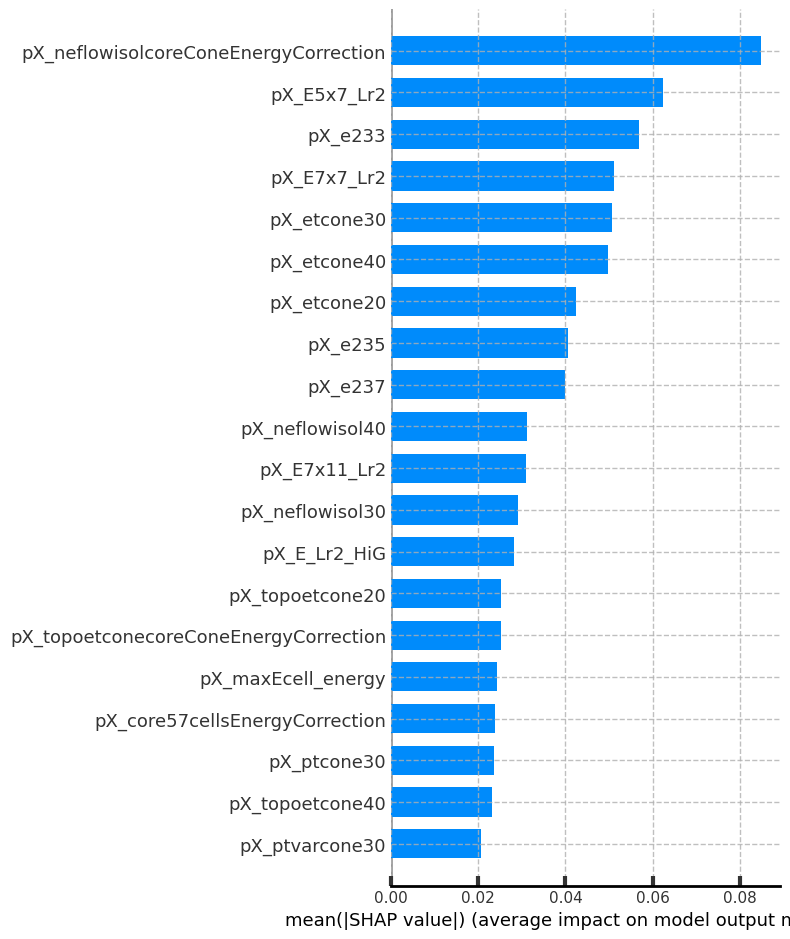

In [64]:
# features_LR = getClsfFeaturesKernel(trainDf, 'LogisticRegression', Nfeatures=20)
# 1 min 30 sec
# 4 min 30 sec
# 1 min 30 sec

100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


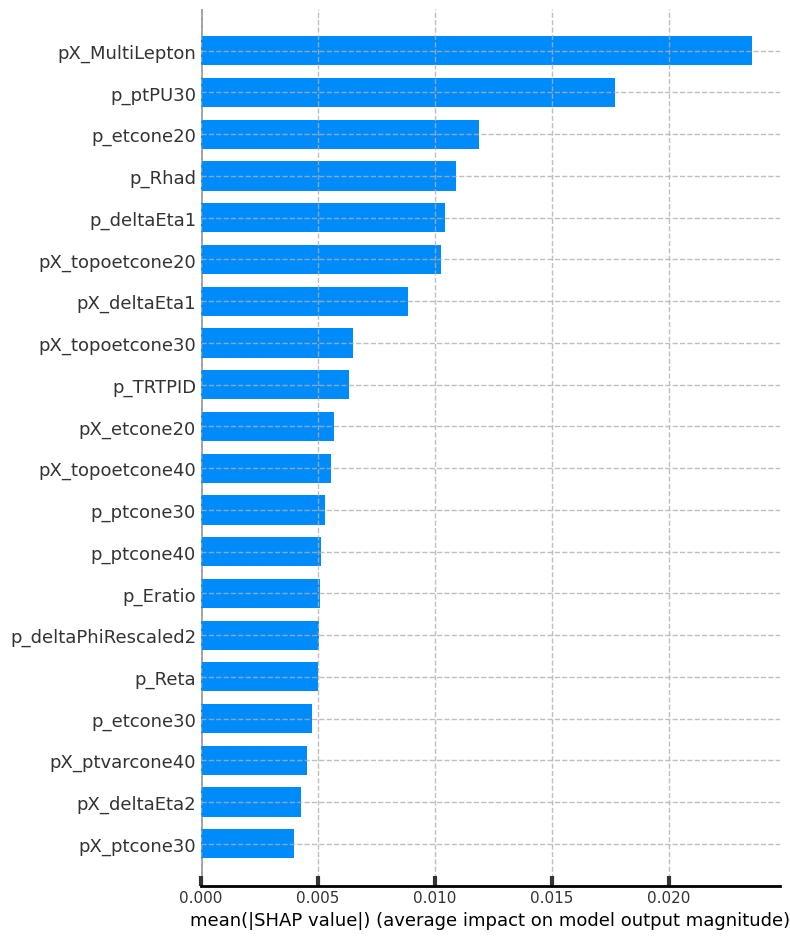

In [65]:
# features_RF = getClsfFeaturesKernel(trainDf, 'RandomForest', Nfeatures=20)
#  4 m 30 s
# 13 m 12 s
# 5 min

c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
100%|██████████| 100/100 [06:06<00:00,  3.66s/it]


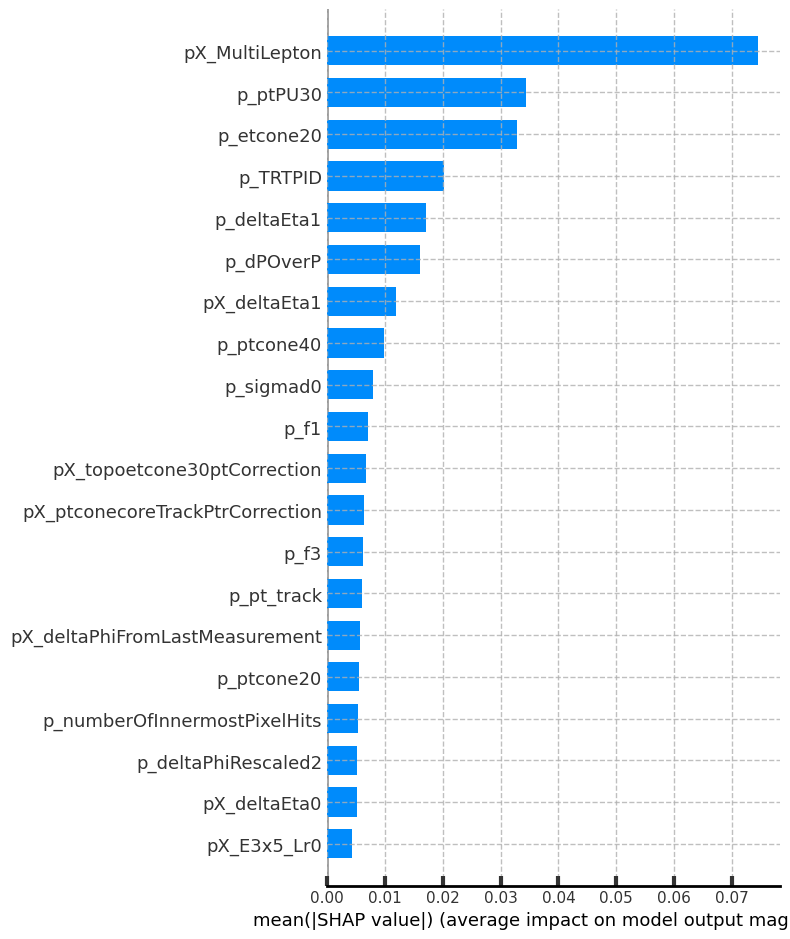

In [66]:
# features_AB = getClsfFeaturesKernel(trainDf, 'AdaBoost', Nfeatures=20)
# 7 m 50 s
# 8 m 

100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


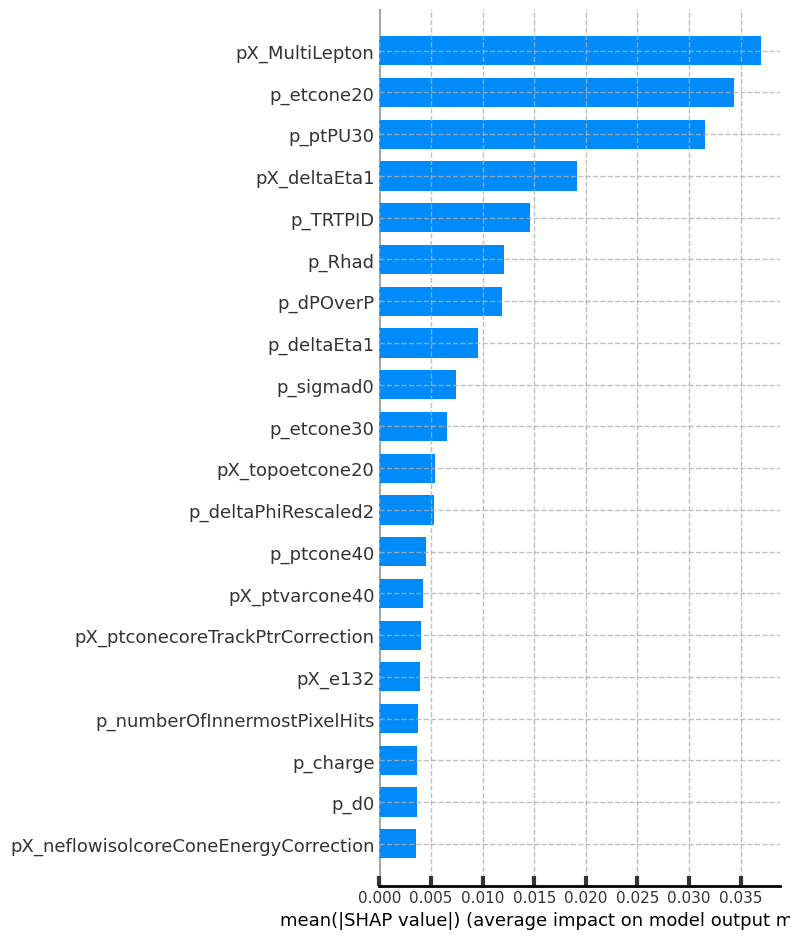

In [67]:
# features_GB = getClsfFeaturesKernel(trainDf, 'GradientBoosting', Nfeatures=20)
# 3 min
# 12 min 30 sec

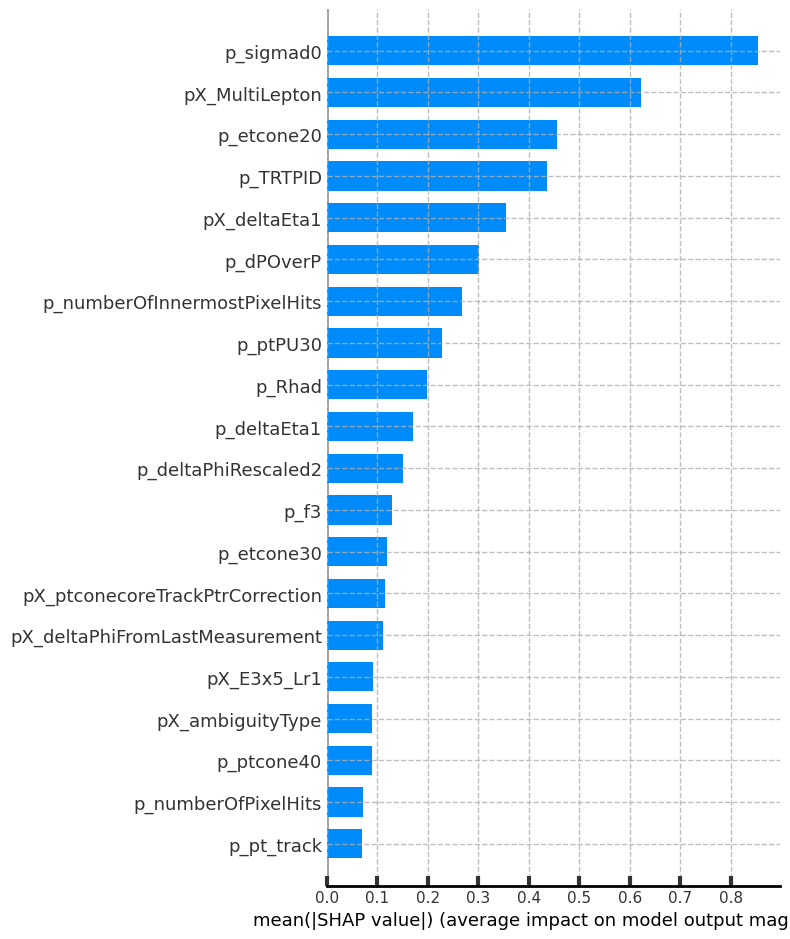

In [68]:
# features_XGB = getClsfFeaturesKernel(trainDf, 'XGBoost', Nfeatures=20)
# TreeExplainer : 10 sec
# 1.7 sec

c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  1%|          | 1/100 [00:04<07:49,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  2%|▏         | 2/100 [00:09<07:25,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  3%|▎         | 3/100 [00:13<07:17,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  4%|▍         | 4/100 [00:18<07:08,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  5%|▌         | 5/100 [00:22<07:03,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  6%|▌         | 6/100 [00:26<06:57,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  7%|▋         | 7/100 [00:31<06:52,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  8%|▊         | 8/100 [00:35<06:53,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
  9%|▉         | 9/100 [00:40<06:45,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 10%|█         | 10/100 [00:44<06:40,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 11%|█         | 11/100 [00:49<06:35,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 12%|█▏        | 12/100 [00:53<06:29,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 13%|█▎        | 13/100 [00:58<06:25,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 14%|█▍        | 14/100 [01:02<06:20,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 15%|█▌        | 15/100 [01:06<06:15,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 16%|█▌        | 16/100 [01:11<06:11,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 17%|█▋        | 17/100 [01:15<06:05,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 18%|█▊        | 18/100 [01:20<06:02,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 19%|█▉        | 19/100 [01:24<05:56,  4.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 20%|██        | 20/100 [01:28<05:53,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 21%|██        | 21/100 [01:33<05:48,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 22%|██▏       | 22/100 [01:37<05:43,  4.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 23%|██▎       | 23/100 [01:42<05:39,  4.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 24%|██▍       | 24/100 [01:46<05:33,  4.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 25%|██▌       | 25/100 [01:50<05:31,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 26%|██▌       | 26/100 [01:55<05:27,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 27%|██▋       | 27/100 [01:59<05:21,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 28%|██▊       | 28/100 [02:04<05:17,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 29%|██▉       | 29/100 [02:08<05:13,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 30%|███       | 30/100 [02:12<05:08,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 31%|███       | 31/100 [02:17<05:04,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 32%|███▏      | 32/100 [02:21<04:59,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 33%|███▎      | 33/100 [02:26<04:55,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 34%|███▍      | 34/100 [02:30<04:51,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 35%|███▌      | 35/100 [02:35<04:46,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 36%|███▌      | 36/100 [02:39<04:42,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 37%|███▋      | 37/100 [02:43<04:38,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 38%|███▊      | 38/100 [02:49<05:04,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 39%|███▉      | 39/100 [02:54<04:51,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 40%|████      | 40/100 [02:58<04:40,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 41%|████      | 41/100 [03:03<04:31,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 42%|████▏     | 42/100 [03:07<04:25,  4.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 43%|████▎     | 43/100 [03:12<04:18,  4.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 44%|████▍     | 44/100 [03:16<04:11,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 45%|████▌     | 45/100 [03:22<04:33,  4.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 46%|████▌     | 46/100 [03:27<04:19,  4.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 47%|████▋     | 47/100 [03:31<04:08,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 48%|████▊     | 48/100 [03:35<03:58,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 49%|████▉     | 49/100 [03:40<03:51,  4.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 50%|█████     | 50/100 [03:44<03:44,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 51%|█████     | 51/100 [03:49<03:38,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 52%|█████▏    | 52/100 [03:53<03:33,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 53%|█████▎    | 53/100 [03:57<03:28,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 54%|█████▍    | 54/100 [04:02<03:24,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 55%|█████▌    | 55/100 [04:06<03:19,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 56%|█████▌    | 56/100 [04:11<03:14,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 57%|█████▋    | 57/100 [04:15<03:10,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 58%|█████▊    | 58/100 [04:20<03:05,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 59%|█████▉    | 59/100 [04:26<03:21,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 60%|██████    | 60/100 [04:32<03:30,  5.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 61%|██████    | 61/100 [04:36<03:15,  5.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 62%|██████▏   | 62/100 [04:41<03:04,  4.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 63%|██████▎   | 63/100 [04:45<02:54,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 64%|██████▍   | 64/100 [04:51<03:04,  5.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 65%|██████▌   | 65/100 [04:55<02:51,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 66%|██████▌   | 66/100 [05:00<02:42,  4.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 67%|██████▋   | 67/100 [05:04<02:34,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 68%|██████▊   | 68/100 [05:09<02:27,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 69%|██████▉   | 69/100 [05:13<02:20,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 70%|███████   | 70/100 [05:18<02:15,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 71%|███████   | 71/100 [05:22<02:10,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 72%|███████▏  | 72/100 [05:26<02:05,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 73%|███████▎  | 73/100 [05:31<02:00,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 74%|███████▍  | 74/100 [05:35<01:55,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 75%|███████▌  | 75/100 [05:40<01:50,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 76%|███████▌  | 76/100 [05:44<01:47,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 77%|███████▋  | 77/100 [05:49<01:42,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 407us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 78%|███████▊  | 78/100 [05:53<01:38,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 79%|███████▉  | 79/100 [05:58<01:33,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 80%|████████  | 80/100 [06:02<01:29,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 81%|████████  | 81/100 [06:06<01:24,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 82%|████████▏ | 82/100 [06:11<01:20,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 83%|████████▎ | 83/100 [06:15<01:15,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 84%|████████▍ | 84/100 [06:20<01:11,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 85%|████████▌ | 85/100 [06:24<01:06,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 86%|████████▌ | 86/100 [06:29<01:02,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 87%|████████▋ | 87/100 [06:33<00:57,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 88%|████████▊ | 88/100 [06:38<00:53,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 385us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 89%|████████▉ | 89/100 [06:42<00:48,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 90%|█████████ | 90/100 [06:46<00:44,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 91%|█████████ | 91/100 [06:51<00:39,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 92%|█████████▏| 92/100 [06:55<00:35,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 93%|█████████▎| 93/100 [07:00<00:31,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 94%|█████████▍| 94/100 [07:04<00:26,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 95%|█████████▌| 95/100 [07:09<00:22,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 96%|█████████▌| 96/100 [07:13<00:17,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 97%|█████████▋| 97/100 [07:18<00:13,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 98%|█████████▊| 98/100 [07:22<00:08,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
 99%|█████████▉| 99/100 [07:26<00:04,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7225/7225 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
100%|██████████| 100/100 [07:31<00:00,  4.51s/it]


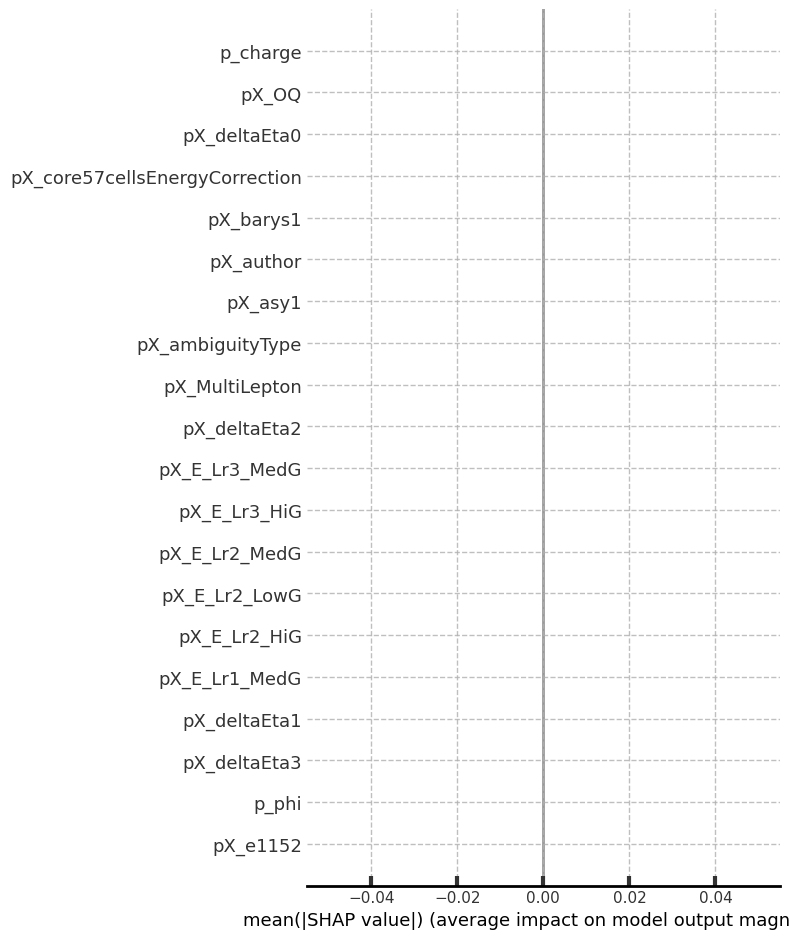

In [69]:
# features_FNN = getClsfFeaturesKernel(trainDf, 'FNN', Nfeatures=20)
# 47 min
# 9 min 30 sec

In [70]:
trainDf.shape

(180000, 147)

In [118]:
# makeVariableCsv(features_LR, 'Classification_CyanYongHoJo_LogisticRegression_VariableList.csv')
# makeVariableCsv(features_RF, 'Classification_CyanYongHoJo_RandomForest_VariableList.csv')
# makeVariableCsv(features_AB, 'Classification_CyanYongHoJo_AdaBoost_VariableList.csv')
# makeVariableCsv(features_GB, 'Classification_CyanYongHoJo_GradientBoosting_VariableList.csv')
# makeVariableCsv(features_XGB, 'Classification_CyanYongHoJo_XGBoost_VariableList.csv')
# makeVariableCsv(features_FNN, 'Classification_CyanYongHoJo_FNN_VariableList.csv')

In [72]:
def getFeatures():
    features = {}
    for classifier in classifiers.keys():
        path = 'solutions/Classification_CyanYongHoJo_' + classifier + '_VariableList.csv'
        features[classifier] = pd.read_csv(path, header=None).values.flatten().tolist()
    return features

In [73]:
selected_features = getFeatures()

In [78]:
# for i in getFeatures()['LogisticRegression']:
#     print(i)

for i in selected_features['FNN']:
    print(i)

pX_etcone20
pX_ptcone20
p_vertex
pX_deltaEta3
p_ptcone30
pX_maxEcell_z
pX_ptvarcone30
pX_maxEcell_y
p_f1
pX_e132
p_dPOverP
pX_r33over37allcalo
averageInteractionsPerCrossing
pX_asy1
pX_nCells_Lr1_HiG
p_Rhad
pX_deltaPhi2
p_truth_parent_pdgId
pX_e2ts1
pX_deltaPhi1


In [128]:
trainDf = readTrainData()
testDf_clsf, testDf_clst, testDf_regs = readTestData()
# 30 sec

In [99]:
trainDf['p_Truth_isElectron']

0         1
1         1
2         1
3         1
4         1
         ..
179995    0
179996    0
179997    0
179998    0
179999    0
Name: p_Truth_isElectron, Length: 180000, dtype: int64

In [136]:
def runClsfCore(trainDf, testDf, key, filename):
    selFeatures = selected_features[key]
    if 'p_Truth_isElectron' in selFeatures:
        selFeatures.remove('p_Truth_isElectron')
    
    commonFeatures = [feature for feature in selFeatures if feature in testDf.columns]
    X_train = trainDf[commonFeatures].values  # Convert to numpy array
    y_train = trainDf['p_Truth_isElectron'].values  # Convert to numpy array

    X_test = testDf[commonFeatures].values  # Convert to numpy array

    print(f"X_train shape: {X_train.shape}, type: {type(X_train)}")  # Debugging
    print(f"y_train shape: {y_train.shape}, type: {type(y_train)}")  # Debugging

    classifier = classifiers[key]
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    saveToCsv(y_pred, filename)

    return y_pred


In [76]:
print(len(testDf_clsf.columns))
print(len(trainDf.columns))

140
147


In [133]:
def runClsf():
    y_preds = {}
    for key in classifiers.keys():
        print(f'--------------------{key}-------------------------')
        y_pred = runClsfCore(trainDf, testDf_clsf, key, f'solutions/Classification_CyanYongHoJo_{key}.csv')
        y_preds[key] = y_pred
        print(f"Predictions for {key} saved.")
    return y_preds

In [155]:
y_preds = runClsf()

--------------------LogisticRegression-------------------------
X_train shape: (180000, 18), type: <class 'numpy.ndarray'>
y_train shape: (180000,), type: <class 'numpy.ndarray'>


KeyboardInterrupt: 

In [156]:
runClsfCore(trainDf, testDf_clsf, 'FNN', f'solutions/Classification_CyanYongHoJo_FNN.csv')

X_train shape: (180000, 19), type: <class 'numpy.ndarray'>
y_train shape: (180000,), type: <class 'numpy.ndarray'>



c:\Users\yhjo7\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
